<a href="https://colab.research.google.com/github/steveseguin/color-grading/blob/master/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Free OBS LUT Maker
This tool is hosted by Google, created by Steve Seguin, and it's free to use, modify, etc. I just ask that any derivation or distribution of this code, commericial or otherwise, gives credit and a link back to the github repo: https://github.com/steveseguin/color-grading

To get the code started, we are going to need to import the needed Python libraries: these empower us to do matrix manipulation, computer vision, and machine learning. Doing this on Google Colab is easy thankfully - just hit the PLAY/RUN button on the code block below.

In [0]:
import cv2 #  computer vision
from google.colab.patches import cv2_imshow

import numpy as np # matrix math
from matplotlib import pyplot as plt # Plotting software to help us visualize some things

from sklearn.preprocessing import PolynomialFeatures  # making math equations
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score # solving math equations

import warnings
warnings.filterwarnings("ignore")  # hides some warnings 

Now lets create our digital color reference chart; or really, an array of RGB color values. This all needs to be based on a physical color reference chart of color values you have. I made my own for free; you can, too, or you can order a professional one online.

For mine, I went to the local paint store and picked up free paper color samples to make my color chart. At a minimum, you will need WHITE, GREY, and BLACK samples. Adding other colors will help, but they are not needed. I picked 9 colors total.

<img src="https://raw.githubusercontent.com/steveseguin/color-grading/master/Image2.png" width="200"/>

If you pick up Behr-branded color samples, you can reference their online website for the RGB values of the colors. ie: https://www.behr.ca/consumer/colors/paint/color/MQ1-02  They may not be 100% accurate, but perhaps good enough.

You can order professional color reference samples also, such as from https://www.amazon.com/Datacolor-SCK200-SpyderCHECKR-24/dp/B00LPS46TW, which may get you better results. Buyer beware though -- not all may work well with this script.

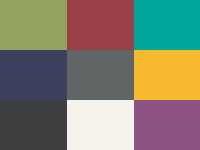

In [91]:
total_rows = 3  # Change to the number of rows in your color chart
total_columns = 3 # Change to the number of columns in your color chart

# Update the follow values with your RGB values.
right = [[147,163,96],[154,64,73],[0,166,153],
		[61,65,93],[96,102,102],[247,185,48],
		[62,63,64],[245,243,236],[138,83,129]] ## [[RGB],[RGB],...[RGB]]  Modify with the RGB values of each color, in the order that you read a book

#R: 0 G: 166 B: 153
#R: 154 G: 64 B: 73
#R: 61 G: 65 B: 93
#R: 247 G: 185 B: 48
#R: 245 G: 243 B: 236
#R: 138 G: 83 B: 129
test = np.array(right).reshape((total_rows,total_columns,3)).astype("uint8") 
test = cv2.cvtColor(test, cv2.COLOR_RGB2BGR)
test = cv2.resize(test,(200,150),interpolation=cv2.INTER_NEAREST)
cv2_imshow(test) ## If the colors don't match, something is wrong. This is our color target for the output

wrong = np.zeros_like(right) 

Below, let's take a photo of our our color reference chart taken with our camera under the lighting conditions we wish to create our OBS-LUT for and upload it to this script.

Image size doesn't matter a whole lot, but make sure the is cropped to fit the image.

Hit Cancel Upload if you want to use the default demo image instead.

Example Image to upload:

<img src="https://raw.githubusercontent.com/steveseguin/color-grading/master/Image1.png" width="200"/>

--2019-10-24 21:45:17--  https://raw.githubusercontent.com/steveseguin/color-grading/master/logcrop.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23917 (23K) [image/jpeg]
Saving to: ‘logcrop.jpg’

logcrop.jpg         100%[===================>]  23.36K  --.-KB/s    in 0.008s  

2019-10-24 21:45:18 (2.94 MB/s) - ‘logcrop.jpg’ saved [23917/23917]



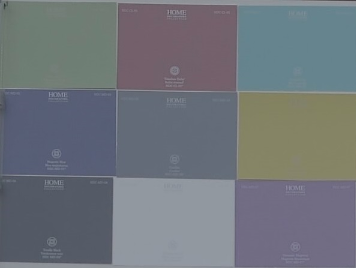

In [92]:
from google.colab import files # lets us upload images to Google Colab from local storage
uploaded = files.upload()
img_file = None

for fn in uploaded.keys():  ## 
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  img_file = fn
  
if (img_file==None): ## If no image is uploaded by user
  !wget https://raw.githubusercontent.com/steveseguin/color-grading/master/logcrop.jpg -O logcrop.jpg  # DOWNLOAD SAMPLE IMAGE
  img_file = "logcrop.jpg"
    
img = cv2.imread(img_file, 1) # LOAD INTO PYTHON
w,h,_ = np.shape(img) # GET SIZE OF IMAGE
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # CONVERT FROM BGR to RGB (OPENCV defaults to BGR for some reason?)

cv2_imshow(cv2.cvtColor(cv2.resize(img,None,fx=0.6,fy=0.6), cv2.COLOR_RGB2BGR)) 

## You may need to re-run this code block a second time if you get an error the first time

We are going to go thru all the colors in the image of the photographed color chart and get the peak RGB colors from it. 

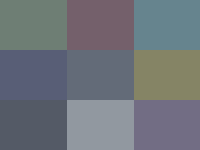

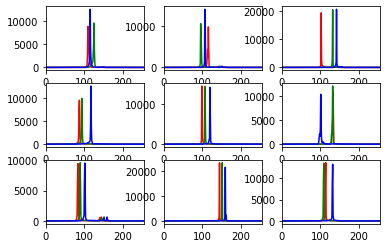

In [93]:

color = ('r','g','b')
for x in range(total_rows):
	for y in range(total_columns):
		for i,col in enumerate(color):
			seg = img[int(x*w/3):int((x+1)*w/3),int(y*h/3):int((y+1)*h/3),:] # We assume each color block is the same size and that the image is cropped correctly
			histr = cv2.calcHist([seg],[i],None,[256],[0,256]) # Create a histogram
			j = x*3+y+1
			wrong[j-1][i]=np.where(np.max(histr)==histr)[0][0] # What is the PEAK color for each block? use this rather than the average RGB value.
			plt.subplot(3,3,j)
			plt.plot(histr,color = col) # Plot, so you can se what's going on.
			plt.xlim([0,256])
			
 # If successful, you should see some plots below. Each plot should have 1 blue, 1 red, and 1 green peak each. 
test = np.array(wrong).reshape((total_rows,total_columns,3)).astype("uint8") 
test = cv2.cvtColor(test, cv2.COLOR_RGB2BGR)
test = cv2.resize(test,(200,150),interpolation=cv2.INTER_NEAREST)
cv2_imshow(test)  ## THIS IS WHAT THE INPUT IT IS; confirm it matches the photo you uploaded.

This next step we are essentially trying to solve a mathematical optimization equation; it will give us our optimized colour-correcting transformation. 

The Basic Logic that we are doing is the following:

```y = a*x^2 + b*x + c ``` , a Polynomial Curve applied to Input Image as a color-transformation

```y1 = (y0 - y)```  , We want the input image to match the target image, or as close as possible.

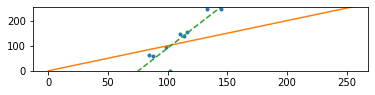

R error: 37.38192869961481
	 ^ High number implies result is not that optimized


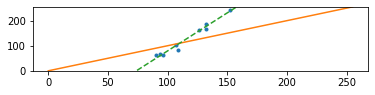

G error: 10.655860494993608


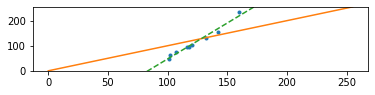

B error: 9.440160572516575


In [94]:
# This is desirable if you are only using Black, White, and Grey -- or just a few colours.
# RGB channels are treated independently, using linear regression fitting

poly={}
colors = ["R","G","B"]
xp = np.linspace(0, 255, 255)
for rgb in range(3):
  www = np.ravel(wrong)[rgb::3]
  rrr = np.ravel(right)[rgb::3]
  pp = 1  ## you can play with the number of polynominals, but more can lead to overfitting. The most you want to try is probably 2
  poly[rgb] = np.polyfit(www, rrr, pp)
  p = np.poly1d(poly[rgb])
  delta = rrr - p(www)
  power = np.power(delta,2)
  mean = np.mean(power)
  final = np.sqrt(mean)
  plt.subplot(3,1,rgb+1)
  _ = plt.plot(www, rrr, '.', xp, xp, '-', xp, p(xp), '--')
  plt.ylim(0,255)
  plt.show()
  print(colors[rgb],"error:",final)
  if (final>30):
     print("\t ^ High number implies result is not that optimized")

PRE range: 0.0 - 255.0
POST range: -277.3944565907328 - 660.920657310106

PRE range: 0.0 - 255.0
POST range: -223.88295306993143 - 549.7021888332405

PRE range: 0.0 - 255.0
POST range: -239.04218308327884 - 491.44216133942155

Coefficients [-2.70257900e+02 -3.58924921e-02 -2.43919215e-02  1.40808811e-05
  3.67085843e+00  3.83555506e-05  4.29732555e-05 -4.22248312e-08]
Coefficients [-2.22655068e+02 -7.85487201e-03  3.03099903e+00  1.01580631e-05
 -3.81966883e-03  1.35078154e-05  1.36843528e-05 -1.53742350e-08]
Coefficients [-2.39114432e+02  2.86134233e+00 -1.29155076e-03  1.25518234e-05
  1.12419051e-03  1.34403610e-05  8.64263930e-06 -4.91645968e-09]


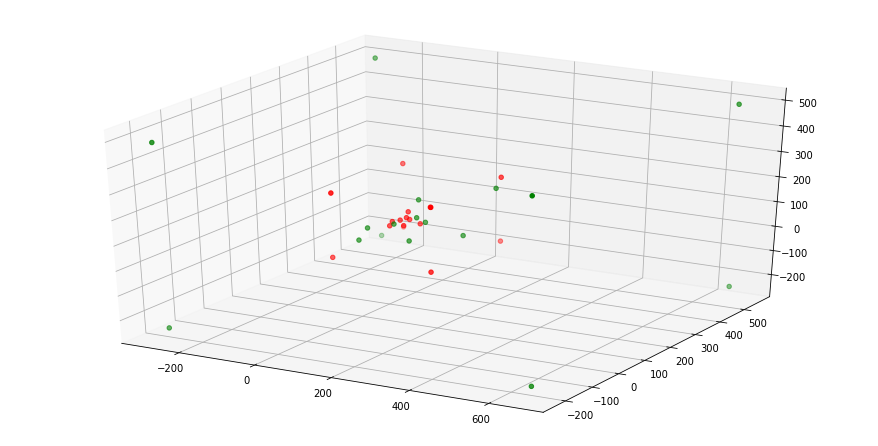

In [95]:
# The previous code block was a set of 1-D regressive linear functions
# This code block tho is a set of 3-D regressive linear functions.  
# Kinda like: R = R0*G0*B0*a, G = R0*G0*B0*b, B = R0*G0*B0*c
# More unstable, but may work better with complex color-modified sources
# THIS IS ALSO A LOT SLOWER. 

grid = np.linspace(0,255, 2)
rainbow = np.zeros((len(grid)*len(grid)*len(grid),3))
ccc = 0
for r in grid:
  for g in grid:
    for b in grid:
      rainbow[ccc,0]=r
      rainbow[ccc,1]=g
      rainbow[ccc,2]=b
      ccc+=1
      
wrong0 = np.vstack((wrong,rainbow))

for rgb in range(3):
  p = np.poly1d(poly[rgb])
  print("PRE range:",np.min(rainbow[:,rgb]),"-",np.max(rainbow[:,rgb]))
  rainbow[:,rgb] = p(rainbow[:,rgb])
  print("POST range:",np.min(rainbow[:,rgb]),"-",np.max(rainbow[:,rgb]))
  print()


right0 = np.vstack((right,rainbow))

r1 = np.ravel(wrong0)[0::3].astype(np.float32, copy=False)  # wrong
g1 = np.ravel(wrong0)[1::3].astype(np.float32, copy=False)
b1 = np.ravel(wrong0)[2::3].astype(np.float32, copy=False)

r0 = np.ravel(right0)[0::3].astype(np.float32, copy=False)  # right
g0 = np.ravel(right0)[1::3].astype(np.float32, copy=False)
b0 = np.ravel(right0)[2::3].astype(np.float32, copy=False)

rgb = np.array([r1,g1,b1])

coes = {}
def polyfit3d(rgb,pp,x0):
    degrees = [(i, j, k) for i in range(pp) for j in range(pp) for k in range(pp)]  # list of monomials x**i * y**j to use
    matrix = np.stack([np.prod(rgb.T**d, axis=1) for d in degrees], axis=-1)   # stack monomials like columns
    coeff = np.linalg.lstsq(matrix, x0)[0]    # lstsq returns some additional info we ignore
    print("Coefficients", coeff)    # in the same order as the monomials listed in "degrees"
    fit = np.dot(matrix, coeff)
    #print(np.sqrt(np.mean((x0-fit)**2)))
    return coeff
  
def poly3d(rgb,coeff,pp):
    degrees = [(i, j, k) for i in range(pp) for j in range(pp) for k in range(pp)]  # list of monomials x**i * y**j to use
    matrix = np.stack([np.prod(rgb.T**d, axis=1) for d in degrees], axis=-1)   # stack monomials like columns
    fit = np.dot(matrix, coeff)
    return fit

ppp=2
coes[0] = polyfit3d(rgb,ppp,r0)
coes[1] = polyfit3d(rgb,ppp,g0)
coes[2] = polyfit3d(rgb,ppp,b0)

rgb0 = np.array([poly3d(rgb,coes[0],ppp),poly3d(rgb,coes[1],ppp), poly3d(rgb,coes[2],ppp)])

from mpl_toolkits.mplot3d import axes3d
import scipy as sp
import scipy.interpolate

fig = plt.figure(figsize=(12,6))
ax = axes3d.Axes3D(fig)

ax.scatter3D(rgb0[0],rgb0[1],rgb0[2], c='g')
ax.scatter3D(rgb[0],rgb[1],rgb[2], c='r') 

We now want to upload an image that we want to colour-correct. This step is optional, but it will let us confirm how well things worked before creating our final OBS-LUT image.

Hit Cancel Upload to use the provided sample image.

--2019-10-24 21:45:33--  https://raw.githubusercontent.com/steveseguin/color-grading/master/log.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1123880 (1.1M) [image/jpeg]
Saving to: ‘log.jpg’

log.jpg             100%[===================>]   1.07M  --.-KB/s    in 0.05s   

2019-10-24 21:45:34 (23.6 MB/s) - ‘log.jpg’ saved [1123880/1123880]



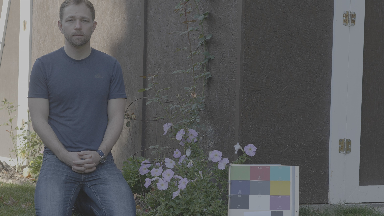

Dynamic range: 14 - 219


In [96]:
from google.colab import files # lets us upload images to Google Colab from local storage
uploaded = files.upload()
img_file = None

for fn in uploaded.keys():  ## 
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  img_file = fn
  
if (img_file==None): ## If no image is uploaded by user
  !wget https://raw.githubusercontent.com/steveseguin/color-grading/master/log.jpg -O log.jpg  # DOWNLOAD SAMPLE IMAGE
  img_file = "log.jpg"

img2 = cv2.imread(img_file, 1)	

cv2_imshow(cv2.resize(img2,None,fx=0.1,fy=0.1))
print("Dynamic range:",np.min(img2),"-",np.max(img2))

img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2 = img2.astype(np.float32, copy=False)

# YOU MAY NEED TO RUN THIS TWICE FOR IT TO WORK

14.0 219.0
(3, 8294400)
-212.62889 524.64453
Consider shooting with more contrast or less dynamic range to get less colour banding


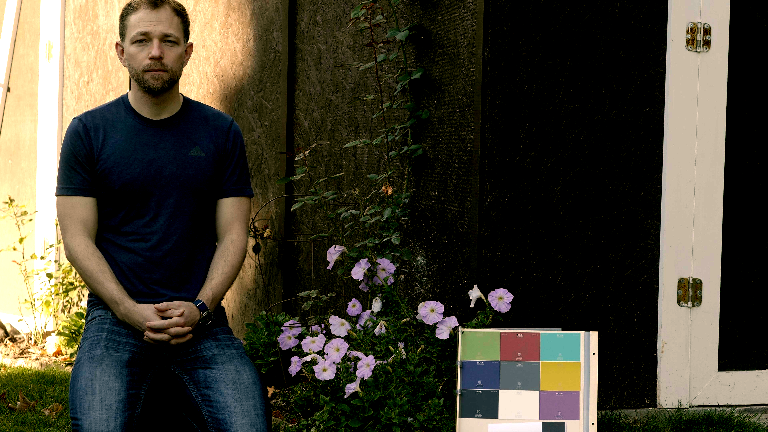

In [97]:
def applyLUT(image):
  assert(image.dtype == "float32")
  for rgb in range(3):
    p = np.poly1d(poly[rgb])
    print("PRE range:",np.min(image[:,:,rgb]),"-",np.max(image[:,:,rgb]))
    image[:,:,rgb] = p(image[:,:,rgb])
    print("POST range:",np.min(image[:,:,rgb]),"-",np.max(image[:,:,rgb]))
    print()
  return image

def applyLUT2(image,pp):
  sss = np.shape(image[:,:,0])
  rgb = image.reshape(-1,3).T
  print(np.shape(rgb))
  Zr = poly3d(rgb,coes[0],pp).reshape(sss)
  Zg = poly3d(rgb,coes[1],pp).reshape(sss)
  Zb = poly3d(rgb,coes[2],pp).reshape(sss)
  image[:,:,0] = Zr
  image[:,:,1] = Zg
  image[:,:,2] = Zb
  return image
  

img = np.zeros_like(img2)
img[:] = img2[:]

## BRIGHTNESS ADJUSTMENT. 
mb = 0   #  -20 to 20 is a good range to try; 0 is default
print(np.min(img),np.max(img))

#img = applyLUT(img) + mb
img = applyLUT2(img,ppp) + mb


print(np.min(img),np.max(img))
if ((np.min(img)>25) & (np.max(img)<230)):
  print("Consider shooting in LOG or reducing contrast on your camera when recording")
elif (np.min(img)>25):
  print("Consider capturing with reduced exposure to capture more shadow detail")
elif (np.max(img)<230):
  print("Consider capturing with increase exposure to capture more highlight detail")
elif ((np.min(img)<-300) or (np.max(img)>500)):
  print("Consider shooting with more contrast or less dynamic range to get less colour banding")

test = np.zeros_like(img)
test[:] = img
test[np.where(test>255)]=255 # cut out bad highlights
test[np.where(test<0)]=0 # cut out bad shadows
test = test.astype(np.uint8, copy=False)

cv2_imshow(cv2.cvtColor(cv2.resize(test,None,fx=0.2,fy=0.2), cv2.COLOR_RGB2BGR))

We will want to add a gentle roll-off at the black/white extremes when color correction is complete; this lets us to keep details in some highlights and shadows. When RGB > 225 or RGB < 30, we will refer to these Look-Up Tables to see how to best increase the dynamic range.

To see the Gamme Curve applied, see here
https://www.desmos.com/calculator/85cadg5cfx

In [0]:

LUT2 = np.zeros((492)) # LIGHT
for y in range(22500,25500):
    x = int(round((y/100-225)/1 + 1/(1.2**(225-y/100))+225))
    LUT2[x-226] = int(round(y/100.0))
LUT1 = 255-np.flip(LUT2)  # DARK

Applying the Gamma Curve to the Image. Optional, but recommended

Post Gamma Curve Dynamic range: 26.0 -> 524.64453
Final Dynamic range: 26 - 255 , Average Lumin Value: 11.910525738129712


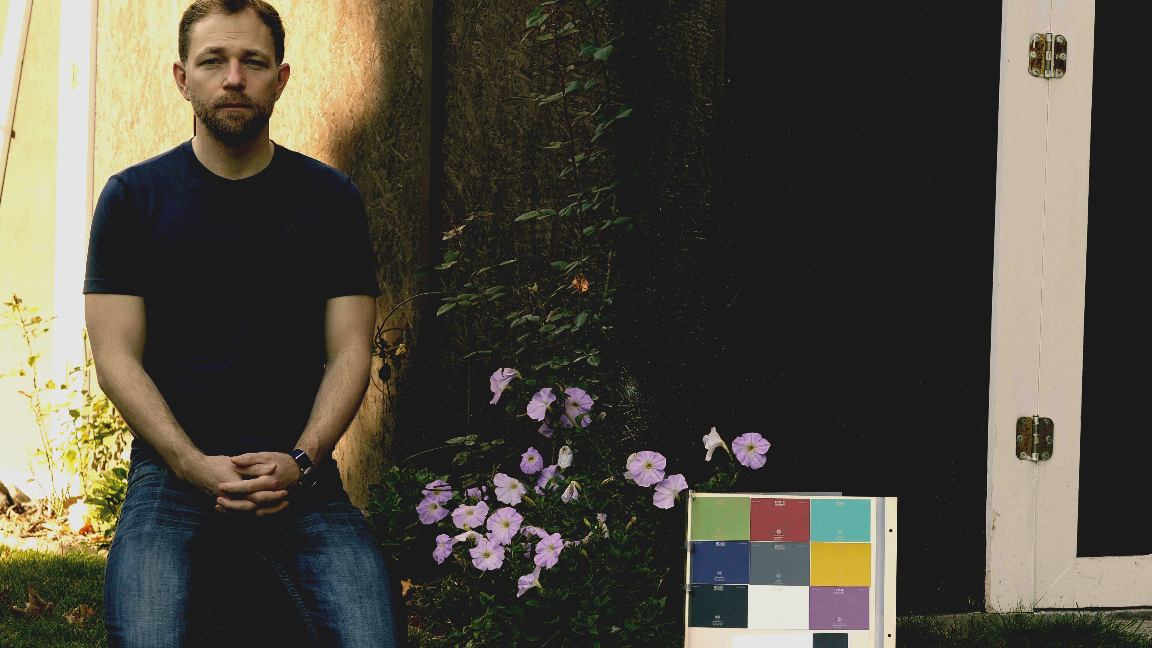

In [109]:
where = np.where((img>225) &(img<492))
out = LUT2[np.uint16(np.round(img[where]-225))].astype(np.float32, copy=False)
img[where] = out
where = np.where((img<=30) & (img>-461))
out = LUT1[np.uint16(np.round(img[where]+461))].astype(np.float32, copy=False)
img[where] = out

print("Post Gamma Curve Dynamic range:",np.min(img),"->",np.max(img))

test = np.zeros_like(img)
test[:] = img[:]
test[np.where(test>254)]=255 # cut out bad highlights
test[np.where(test<1)]=0 # cut out bad shadows
test = test.astype(np.uint8, copy=False)
avglum = np.mean(np.sqrt( 0.299*test[:,:,0]**2 + 0.587*test[:,:,1]**2 + 0.114*test[:,:,2]**2 ))
print("Final Dynamic range:",np.min(test),"-",np.max(test), ", Average Lumin Value:",avglum)
cv2_imshow(cv2.cvtColor(cv2.resize(test,None,fx=0.3,fy=0.3), cv2.COLOR_RGB2BGR))

And Finally, using what we tried out above, we can generate our OBS LUT as a PNG file. You can customize the code as needed. Just right click the LUT Image once it is generated to save and download it for use in OBS or elsewhere.

--2019-10-24 21:48:57--  https://raw.githubusercontent.com/steveseguin/color-grading/master/neutral-lut.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1627 (1.6K) [image/png]
Saving to: ‘neutral-lut.png’

neutral-lut.png     100%[===================>]   1.59K  --.-KB/s    in 0s      

2019-10-24 21:48:57 (344 MB/s) - ‘neutral-lut.png’ saved [1627/1627]

PRE PROCESSING - Dynamic range: 0 - 255 , Average Lumin Value: 9.954046647274684

 R-> G-> B-> 

PRE range: 0.0 - 255.0
POST range: -277.39447 - 660.9206

PRE range: 0.0 - 255.0
POST range: -223.88295 - 549.7022

PRE range: 0.0 - 255.0
POST range: -239.04219 - 491.4422

POST-PROCESSING - Dynamic range: 0 - 255 , Average Lumin Value: 6.858018846434242

Done processing!
--> RIGHT CLICK IMAGE AND SELECT 'SAVE IM

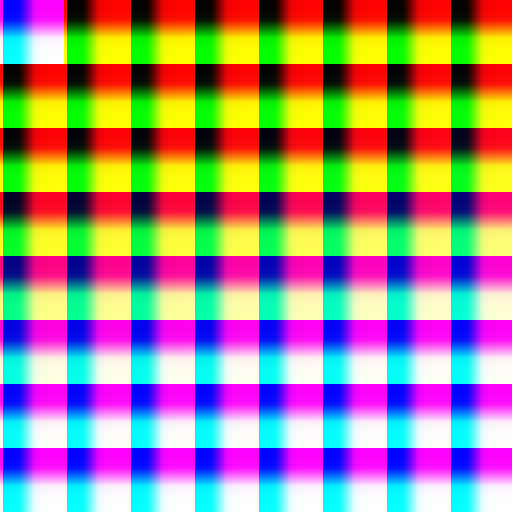

In [104]:
## We are going to download a "neutral" PNG LUT and modify it. You can use your own LUTs instead if you want to modify the code a bit
!wget https://raw.githubusercontent.com/steveseguin/color-grading/master/neutral-lut.png -O neutral-lut.png  # DOWNLOAD LUT FROM GITHUB
img_file = "neutral-lut.png"

# LOAD INTO PYTHON
lutimg = cv2.imread(img_file, 1) 
lutimg = cv2.cvtColor(lutimg, cv2.COLOR_BGR2RGB)

## ANALYTICS
avglum = np.mean(np.sqrt( 0.299*lutimg[:,:,0]**2 + 0.587*lutimg[:,:,1]**2 + 0.114*lutimg[:,:,2]**2 ))  # via: https://stackoverflow.com/questions/596216/formula-to-determine-brightness-of-rgb-color
print("PRE PROCESSING - Dynamic range:",np.min(lutimg),"-",np.max(lutimg), ", Average Lumin Value:",avglum)

lutimg = lutimg.astype(np.float32, copy=False)

## If we want to increase the brightness
## We will use what was set earlier if not defined below
# mb = 0
if (mb!=0):
  print()
  print("\tfyi: Brightness is being adjusted from default; adding",str(mb),"more brightness")
  
print()
print(" R-> G-> B-> ")
print()

## APPLY THE COLOR CORRECTION
lutimg = applyLUT(lutimg) + mb
#lutimg = applyLUT2(lutimg,ppp) + mb  ## Experimental alternative to applyLUT

## APPLY HIGHLIGHT GAMMA CURVE
where = np.where((lutimg>225) &(lutimg<492))
out = LUT2[np.uint16(np.round(lutimg[where]-225))]
lutimg[where] = out

## APPLY SHADOW GAMMA CURVE
where = np.where((lutimg<=30) & (lutimg>-461))  
out = LUT1[np.uint16(np.round(lutimg[where]+461))]
lutimg[where] = out

## CLEAN UP OUT-OF-BOUNDS DATA
lutimg[np.where(lutimg>255)]=255 # cut out bad highlights
lutimg[np.where(lutimg<0)]=0 # cut out bad shadows
lutimg = lutimg.astype(np.uint8, copy=False)

## ANALYTICS
avglum = np.mean(np.sqrt( 0.299*lutimg[:,:,0]**2 + 0.587*lutimg[:,:,1]**2 + 0.114*lutimg[:,:,2]**2 ))  # via: https://stackoverflow.com/questions/596216/formula-to-determine-brightness-of-rgb-color
print("POST-PROCESSING - Dynamic range:",np.min(lutimg),"-",np.max(lutimg), ", Average Lumin Value:",avglum)
print()
print("Done processing!")
print("--> RIGHT CLICK IMAGE AND SELECT 'SAVE IMAGE AS' TO SAVE; as .png filetype ideally <--")
## GENERATE THE FINAL LUT
cv2_imshow(cv2.cvtColor(lutimg,cv2.COLOR_RGB2BGR)) 


# TIPS FOR IMPROVING RESULTS

### Low contrast results...
Based on our sample test data, our results show that our OBS-LUT has a Dynamic range of 0 to 255. Since we were using a LOG profile as input, we generated a fairly dynamic LUT profile. If the source image is of high contrast and low dynamic range though, or perhaps its too dark or too bright, the resultant LUT may be of low dynamics with a range of 30 to 240. In such cases, it might be best to adjust in-camera settings to reduce contrast or change exposure to optimize things.

If not possible to change camera settings, we can also adjust this issue in OBS, perhaps by increasing contrast after the LUT is applied, but that may lead to increased color banding. Another option is to reduce the amount of LUT applied to just 80%; a blended mix of original and transformed content.

### Overly WARM/DARK/BLUE/GREEN/WHITE results..

When we import a LUT into OBS, we may find that the color is too warm or too cold or too dark. Reduce the "Amount" of LUT filtering applied to the image in OBS, perhaps to 80%, to get a good balance of original input and the LUT. This can also help with banding or highlight/shadow issues. 

Another option is to modify the "mb" variable, to increase or reduce brightness, before the LUT is generated. See the code above for more details there.

Try also putting the Color Reference board you have in different lighting; too bright or too dark and it may cause the image to become too bright or too dark. Ideally, it should be getting balanced lighting.

You may also need to double check that all your color-cards are correctly calibrated and measured. Sometimes reducing your colors to just white, grey, and black can help reduce color shifts. Sometimes adding many more colors can also help. Experiment.

<img src="https://raw.githubusercontent.com/steveseguin/color-grading/master/obs-layout.jpg" width="700"/>

### Don't use OBS?
If OBS is not something you use, and you would just like to apply such a LUT to a static video file you have, you can modify the above code to work with video files.

An additional benefit of this approach is that the LUT used would not not be bound by 0-255, but rather -250 to +450, so less data would be lost within the highlights and shadows. It can also be configured to work with 10-bit video files to retain even more data.

Please see my github repo for a downloadable version of these scripts that you can try to apply on videos. Beware though: the code for such a task is only partially complete at current. I wouldn't' recommend this however unless you are a Python programmer or are willing to cough up a lot of cash to get me to continue working on it for you.


Cheers!

-steve